In [57]:
import pandas as pd
import math
import numpy as np
import datetime as dt
import time

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from xgboost import XGBRegressor, cv, DMatrix

In [60]:
stock_df = pd.read_excel("drive/MyDrive/playground/product_analysis/main_code/product_data.xlsx")

In [61]:
print(stock_df.shape)
stock_df.head()

(2000, 7)


,date,product_sku,price,store,is_promo_item,member_promo,quantity
0,2019-11-29,sku021,147454.56,storeA013,0.0,1.0,18.0
1,2020-01-15,sku022,4303058.84,storeA006,1.0,0.0,3.0
2,2020-01-28,sku023,1742713.52,storeA017,1.0,0.0,9.0
3,2019-12-05,sku024,4656476.03,storeA007,0.0,1.0,8.0
4,2020-01-04,sku025,4774574.30,storeA015,0.0,0.0,1.0


In [62]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           1954 non-null   datetime64[ns]
 1   product_sku    1900 non-null   object        
 2   price          1900 non-null   float64       
 3   store          1959 non-null   object        
 4   is_promo_item  1959 non-null   float64       
 5   member_promo   1907 non-null   float64       
 6   quantity       1959 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 109.5+ KB


In [63]:
stock_df.describe(include = 'all')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



,date,product_sku,price,store,is_promo_item,member_promo,quantity
count,1954,1900,1.900000e+03,1959,1959.000000,1907.000000,1959.000000
unique,91,31,NaN,28,NaN,NaN,NaN
top,2019-12-06 00:00:00,sku027,NaN,storeA005,NaN,NaN,NaN
freq,32,66,NaN,89,NaN,NaN,NaN
first,2019-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,2020-01-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,2.550844e+06,NaN,0.505360,0.489250,10.451251
std,NaN,NaN,1.398276e+06,NaN,0.500099,0.500016,5.777413
min,NaN,NaN,1.094172e+05,NaN,0.000000,0.000000,1.000000
25%,NaN,NaN,1.405427e+06,NaN,0.000000,0.000000,6.000000


#### Null Analysis

Checking for null values

In [64]:
# Get Null Values in all columns Function

def null_value_analysis(df):
    the_data = pd.DataFrame(df.isnull().sum()).reset_index()
    the_data.rename(columns = {'index': 'col_name', 0:'total'}, inplace = True)
    
    # Calculate the percentage of null value among the whole row of data
    the_data['percentage'] = round(the_data['total'] / df.shape[0] * 100, 2)

    return the_data

In [65]:
null_value_analysis(stock_df)

,col_name,total,percentage
0,date,46,2.30
1,product_sku,100,5.00
2,price,100,5.00
3,store,41,2.05
4,is_promo_item,41,2.05
5,member_promo,93,4.65
6,quantity,41,2.05


In [66]:
date_null = (stock_df['date'].isnull())
sku_null = (stock_df['product_sku'].isnull())
price_null = (stock_df['price'].isnull())
store_null = (stock_df['store'].isnull())
promo_item_null = (stock_df['is_promo_item'].isnull())
member_promo_null = (stock_df['member_promo'].isnull())
quantity_null = (stock_df['quantity'].isnull())

# Getting rows that have NULL values for all features
all_null_df = stock_df[date_null & sku_null & price_null & store_null & promo_item_null & member_promo_null & quantity_null]
partial_null_df = stock_df[date_null | sku_null | price_null | store_null | promo_item_null | member_promo_null | quantity_null]

print('Rows of null value for all columns : {} \t| Percentage : {}%'.format(all_null_df.shape[0], all_null_df.shape[0]/ stock_df.shape[0] * 100))
print('Rows of null value for partial columns : {} \t| Percentage : {}%'.format(partial_null_df.shape[0], partial_null_df.shape[0]/ stock_df.shape[0] * 100))


Rows of null value for all columns : 0 	| Percentage : 0.0%
Rows of null value for partial columns : 266 	| Percentage : 13.3%


In [67]:
partial_null_df.head()

,date,product_sku,price,store,is_promo_item,member_promo,quantity
10,2020-01-01,sku031,650517.59,storeA002,0.0,NaN,18.0
15,2019-12-01,sku036,2142773.49,NaN,NaN,1.0,NaN
17,2020-01-24,NaN,NaN,storeA027,1.0,0.0,7.0
18,2019-11-27,sku039,4922293.00,storeA012,0.0,NaN,6.0
19,2019-11-15,sku040,2847936.18,storeA011,1.0,NaN,16.0


As can be seen from above 2 cells, there is no rows that have all NULL, but there are 266 rows that have partially Null (around 13.3%) out of the whole row. For now, let's drop all rows that have null values everywhere. And when we're trying to build a better model, we could try to impute the missing values and compare the result with the other models.

In [68]:
stock_df_nonull = stock_df.dropna(axis = 0, how = 'any')

print(stock_df_nonull.shape)
stock_df_nonull.head()

(1734, 7)


,date,product_sku,price,store,is_promo_item,member_promo,quantity
0,2019-11-29,sku021,147454.56,storeA013,0.0,1.0,18.0
1,2020-01-15,sku022,4303058.84,storeA006,1.0,0.0,3.0
2,2020-01-28,sku023,1742713.52,storeA017,1.0,0.0,9.0
3,2019-12-05,sku024,4656476.03,storeA007,0.0,1.0,8.0
4,2020-01-04,sku025,4774574.30,storeA015,0.0,0.0,1.0


In [ ]:
# stock_df_nonull.to_csv('stock_df_nonull.csv', index=False)

Since there is a feature with timestamp, let's try to break it down into several features. That way we could get more features and we could identify if there's any seasonality in the data that would make our prediction power stronger.

In [70]:
stock_df_nonull.loc[:,'day_num'] = stock_df_nonull.loc[:,'date'].dt.day
stock_df_nonull.loc[:,'month_num'] = stock_df_nonull.loc[:,'date'].dt.month
stock_df_nonull.loc[:,'year_num'] = stock_df_nonull.loc[:,'date'].dt.year
stock_df_nonull.loc[:,'day_name'] = stock_df_nonull.loc[:,'date'].dt.day_name()
stock_df_nonull.loc[:,'week_num'] = stock_df_nonull.loc[:,'date'].dt.week
stock_df_nonull.loc[:,'year_month'] = stock_df_nonull.loc[:, 'year_num'].astype(str) + '-' + stock_df_nonull.loc[:, 'month_num'].astype(str)
stock_df_nonull.loc[:,'year_week'] = stock_df_nonull.loc[:, 'year_num'].astype(str) + '-' + stock_df_nonull.loc[:, 'week_num'].astype(str)
stock_df_nonull.loc[:,'wom'] = stock_df_nonull.loc[:,'date'].apply(lambda d: (d.day-1) // 7 + 1)

stock_df_nonull.loc[:, 'revenue'] = stock_df_nonull.loc[:, 'quantity'] * stock_df_nonull.loc[:, 'price']


stock_df_nonull.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



,date,product_sku,price,store,is_promo_item,member_promo,quantity,day_num,month_num,year_num,day_name,week_num,year_month,year_week,wom,revenue
0,2019-11-29,sku021,147454.56,storeA013,0.0,1.0,18.0,29,11,2019,Friday,48,2019-11,2019-48,5,2654182.08
1,2020-01-15,sku022,4303058.84,storeA006,1.0,0.0,3.0,15,1,2020,Wednesday,3,2020-1,2020-3,3,12909176.52
2,2020-01-28,sku023,1742713.52,storeA017,1.0,0.0,9.0,28,1,2020,Tuesday,5,2020-1,2020-5,4,15684421.68
3,2019-12-05,sku024,4656476.03,storeA007,0.0,1.0,8.0,5,12,2019,Thursday,49,2019-12,2019-49,1,37251808.24
4,2020-01-04,sku025,4774574.30,storeA015,0.0,0.0,1.0,4,1,2020,Saturday,1,2020-1,2020-1,1,4774574.30


### Analysis Based on Store

In [21]:
###### Mean Qty per store
store_mean_qty_dict = {'store': stock_df_nonull['store'].unique(),
                       'mean':[stock_df_nonull['quantity'].mean()] * len(stock_df_nonull['store'].unique())}

store_mean_qty = pd.DataFrame(store_mean_qty_dict)

# Number of product that every store has
num_unique_sku = pd.DataFrame(stock_df_nonull.groupby('store')['product_sku'].nunique()).reset_index()
num_unique_sku.rename(columns = {'product_sku':'total'}, inplace = True)

# Total Revenue per store
rev_store = pd.DataFrame(stock_df_nonull.groupby('store')['revenue'].sum()).reset_index()

# Total quantity sold per store per product
total_quantity = pd.DataFrame(stock_df_nonull.groupby(['store', 'product_sku'])['quantity'].sum()).reset_index()
total_quantity.rename(columns = {'quantity' : 'total_quantity'}, inplace = True)

# Total revenue per day
tot_rev_daily = pd.DataFrame(stock_df_nonull.groupby(['day_num'])['revenue'].sum()).reset_index()
# tot_rev_daily.rename(columns = {'quantity' : 'revenue'}, inplace = True)

# Total quantity per month
tot_quantity_monthly = pd.DataFrame(stock_df_nonull.groupby(['month_num'])['quantity'].sum()).reset_index()
tot_quantity_monthly.rename(columns = {'quantity' : 'total_quantity'}, inplace = True)
tot_quantity_monthly.sort_values(by = 'month_num')

# Total Quantity by date
tot_quantity_date = pd.DataFrame(stock_df.groupby(['date'])['quantity'].sum()).reset_index()
tot_quantity_date.rename(columns = {'quantity' : 'total_quantity'}, inplace = True)

# Total Revenue by Data
tot_rev_date = pd.DataFrame(stock_df_nonull.groupby(['date'])['revenue'].sum()).reset_index()

##### START PLOT #####
fig1 = go.Figure()
fig1 = go.Figure()
fig1.add_trace(go.Bar(x=num_unique_sku['store'],
                y=num_unique_sku['total'],
                name='Num Unique',
                marker_color='rgb(55, 83, 109)',
                text = num_unique_sku['total'],
                textposition = 'auto'
                ))

fig1.update_layout(title_text='Number of Unique SKU per Store',
                  xaxis_title = 'Store Name',
                  yaxis_title = 'Number of Product')
fig1.show()

################# Quantity Sold Distribution per Store
fig2 = go.Figure()
fig2.add_trace(go.Box(y=stock_df_nonull['quantity'], x=stock_df_nonull['store'], boxmean=True,
                     marker_color = '#27496d', name = 'Qty Distribution'))

fig2.add_trace(go.Scatter(x=store_mean_qty['store'], y = store_mean_qty['mean'],mode='lines',
                         name = 'Mean Qty Sold', line=dict(color='firebrick', width=3,dash='dash')
                         )
              )

fig2.update_layout(title_text = 'Quantity Sold per Store',
                  xaxis_title = 'Store Name',
                  yaxis_title = 'Qty Sold')

fig2.show()

################# Revenue Distribution per Store
fig3 = go.Figure()
fig3.add_trace(go.Box(y=stock_df_nonull['revenue'], x=stock_df_nonull['store'], boxmean=True,
                     marker_color = '#434e52'))

fig3.update_layout(title_text = 'Revenue Distribution per Store',
                  xaxis_title = 'Store Name',
                  yaxis_title = 'Revenue')

fig3.show()


* **Number of Unique SKU per Store**
    * For all of the store in the data, they have similar number of product they are selling.
    * This means that there are no biases on which store has the most complete items. If there is a bias, customers would tend to buy to a store that sells most products being sold.
* **Quantity Sold per Store**
    * Max sold = 20 for all store
    * storeA014 has higher average quantity sold compared to other stores.
    * the quantity sold distribution for this store is left skewed with long tail, meaning that the number of products sold in this store are close to the max number of item sold.
* **Revenue Distribution per Store**
    * store A014 has higher average revenue compared to the others and high variability in gaining a revenue.
    * Other than that, this store has the least difference of mean and median, meaning that it has a symmetrical distribution.
    * When there is a symmetrical distribution (approaching Normal Distribution), it means that it is more accurate to estimate a store's revenue by just getting the average of the revenue.

### Analysis Based on Product SKU

In [22]:
#### Product mean Quantity
product_mean_qty_dict = {'product': stock_df_nonull['product_sku'].unique(),
                       'mean':[stock_df_nonull['quantity'].mean()] * len(stock_df_nonull['product_sku'].unique())}

product_mean_qty = pd.DataFrame(store_mean_qty_dict)

########### Products sold
qty_sold = pd.DataFrame(stock_df_nonull.groupby(['product_sku'])['quantity'].sum()).reset_index()

fig = go.Figure()

fig.add_trace(go.Bar(x = qty_sold['product_sku'], y = qty_sold['quantity'], text = qty_sold['quantity'],
                    textposition = 'auto', marker_color = '#42240c'))
fig.update_layout(title_text = 'Product Sold', xaxis_title = 'Product SKU', yaxis_title = 'Total QTY')

fig.show()

#################### Quantity Sold Distribution per Product SKU
fig2 = go.Figure()

fig2.add_trace(go.Box(x = stock_df_nonull['product_sku'], y = stock_df_nonull['quantity'], boxmean = True))
fig2.update_layout(title_text = 'Quantity Sold Distribution per Product SKU', 
                   xaxis_title = 'Product SKU', yaxis_title = 'QTY Sold')

fig2.show()

#################### Revenue Distribution per Product SKU
fig3 = go.Figure()

fig3.add_trace(go.Box(x = stock_df_nonull['product_sku'], y = stock_df_nonull['revenue'], boxmean = True))
fig3.update_layout(title_text = 'Revenue Distribution per Product SKU', 
                   xaxis_title = 'Product SKU', yaxis_title = 'Revenue')

fig3.show()

* **Product Sold**
    * Of all products, sku046 is most popular product of all time. However, sku038 has the least popularity among other products.
* **Quantity Sold Distribution per Product SKU**
    * Range of the quantity sold is from 1 to 20.
    * To add from the previous analysis, sku038 has the least average amount sold. And also, this product is skewed right, meaning that most of the quantity sold were in the lower range.
    * All products were sold almost on the same average, around 9 to 11.

### Is it more appealing for customers to purchase promo item? Or purchase items with member promo? Or both? Or no special promo at all?

In [23]:
mem_promo_0 = (stock_df_nonull['member_promo'] == 0)
mem_promo_1 = (stock_df_nonull['member_promo'] == 1)
promo_item_0 = (stock_df_nonull['is_promo_item'] == 0)
promo_item_1 = (stock_df_nonull['is_promo_item'] == 1)


memprom0_itemprom0 = stock_df_nonull[mem_promo_0 & promo_item_0]
memprom0_itemprom0 = pd.DataFrame(memprom0_itemprom0.groupby(['product_sku'])['quantity'].sum()).reset_index()

memprom0_itemprom1 = stock_df_nonull[mem_promo_0 & promo_item_1]
memprom0_itemprom1 = pd.DataFrame(memprom0_itemprom1.groupby(['product_sku'])['quantity'].sum()).reset_index()

memprom1_itemprom0 = stock_df_nonull[mem_promo_1 & promo_item_0]
memprom1_itemprom0 = pd.DataFrame(memprom1_itemprom0.groupby(['product_sku'])['quantity'].sum()).reset_index()

memprom1_itemprom1 = stock_df_nonull[mem_promo_1 & promo_item_1]
memprom1_itemprom1 = pd.DataFrame(memprom1_itemprom1.groupby(['product_sku'])['quantity'].sum()).reset_index()

######  PLOTTING ######
fig = go.Figure()

fig.add_trace(go.Bar(x= memprom0_itemprom0['product_sku'], y = memprom0_itemprom0['quantity'],
                    name = 'No Promo', marker_color = '#ffd082'))
fig.add_trace(go.Bar(x= memprom0_itemprom1['product_sku'], y = memprom0_itemprom1['quantity'],
                    name = 'Promo Item', marker_color = '#678a74'))
fig.add_trace(go.Bar(x= memprom1_itemprom0['product_sku'], y = memprom1_itemprom0['quantity'],
                    name = 'Member Promo', marker_color = '#a7e9af'))
fig.add_trace(go.Bar(x= memprom1_itemprom1['product_sku'], y = memprom1_itemprom1['quantity'],
                    name = 'Both Promo', marker_color = '#ff7c7c'))


fig.update_layout(title_text = 'Comparison of Quantity Sold by Promo Type',
                 xaxis_title = 'Product SKU', 
                  yaxis_title = 'Quantity',
                  legend_orientation = 'h',
                 legend=dict(x=0, y=1.1))

fig.show()

* Popular products when the item is on promo and get a member promo:
    * 021
    * 022
    * 024
    * 028
    * 038
    * 041
    * 046
    * 048
* Popular products when item has no promo at all:
    * 026
    * 029
    * 032
    * 033
    * 034
    * 035
    * 037
    * 039
    * 040
    * 042
    * 044
    * 049
* Popular products for promo item:
    * 025
    * 030
    * 031
* Popular products for member promo:
    * 023
    * 027
    * 036
    * 043
    * 045
    * 047
    * 050
    * 051

| Product Promo | Total Number of Products Sold |
| :-: | :-: |
| No Promo | 12 |
| Promo Items Only | 3 |
| Member Promo Only | 8 |
| Both Promos | 8 |

#### In conclusion, there are more items sold even when there's no promo at all.

In [24]:
no_promo_list = ['sku026', 'sku029', 'sku032', 'sku033', 'sku034', 'sku035', 'sku037', 'sku039', 'sku040',
                 'sku042', 'sku044', 'sku049']

no_promo_items = stock_df_nonull[(stock_df_nonull['product_sku'].isin(no_promo_list)) & 
                                mem_promo_0 & promo_item_0]
no_promo_items.sort_values(by = 'product_sku').head()

,date,product_sku,price,store,is_promo_item,member_promo,quantity,day_num,month_num,year_num,day_name,week_num,year_month,year_week,wom,revenue
1687,2019-12-18,sku026,2140997.06,storeA026,0.0,0.0,13.0,18,12,2019,Wednesday,51,2019-12,2019-51,3,27832961.78
1346,2019-11-22,sku026,4863376.49,storeA027,0.0,0.0,19.0,22,11,2019,Friday,47,2019-11,2019-47,4,92404153.31
36,2019-12-12,sku026,998986.13,storeA007,0.0,0.0,19.0,12,12,2019,Thursday,50,2019-12,2019-50,2,18980736.47
191,2019-12-12,sku026,2185963.92,storeA020,0.0,0.0,2.0,12,12,2019,Thursday,50,2019-12,2019-50,2,4371927.84
1315,2019-11-21,sku026,3649459.33,storeA021,0.0,0.0,13.0,21,11,2019,Thursday,47,2019-11,2019-47,3,47442971.29


#  ----------------------------------------------------------------------------------------------------------------

### When do customers look for promo items? And are they looking for cheaper or more expensive items?

In [25]:
day_name_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sorterIndex = dict(zip(day_name_list, range(len(day_name_list))))

####### Promo Item Only
promo_item_only = stock_df_nonull[(mem_promo_0 & promo_item_1)]
pio_qty_date = pd.DataFrame(promo_item_only.groupby(['date'])['quantity'].mean()).reset_index()
pio_qty_month = pd.DataFrame(promo_item_only.groupby(['year_month'])['quantity'].mean()).reset_index()
pio_qty_day = pd.DataFrame(promo_item_only.groupby(['day_num'])['quantity'].mean()).reset_index()

pio_qty_dayname = pd.DataFrame(promo_item_only.groupby(['day_name'])['quantity'].mean()).reset_index()
pio_qty_dayname['day_name_rank'] = pio_qty_dayname['day_name'].map(sorterIndex)
pio_qty_dayname.sort_values(by = 'day_name_rank', inplace = True)

###### Member Promo Only
member_promo_only = stock_df_nonull[(mem_promo_1 & promo_item_0)]
mpo_qty_date = pd.DataFrame(member_promo_only.groupby(['date'])['quantity'].mean()).reset_index()
mpo_qty_month = pd.DataFrame(member_promo_only.groupby(['year_month'])['quantity'].mean()).reset_index()
mpo_qty_day = pd.DataFrame(member_promo_only.groupby(['day_num'])['quantity'].mean()).reset_index()

mpo_qty_dayname = pd.DataFrame(member_promo_only.groupby(['day_name'])['quantity'].mean()).reset_index()
mpo_qty_dayname['day_name_rank'] = mpo_qty_dayname['day_name'].map(sorterIndex)
mpo_qty_dayname.sort_values(by = 'day_name_rank', inplace = True)

mean_qty_date = stock_df_nonull.loc[(mem_promo_0 & promo_item_1) | (mem_promo_1 & promo_item_0), :]


In [26]:
############# FULL DATE
fig = go.Figure()

fig.add_trace(go.Scatter(x = pio_qty_date['date'], y = pio_qty_date['quantity'], name = 'Promo Item Qty', 
                         mode = 'lines+markers'))

fig.add_trace(go.Scatter(x = mpo_qty_date['date'], y = mpo_qty_date['quantity'], name = 'Member Promo Qty', 
                         mode = 'lines+markers'))

fig.update_layout(title_text = 'Average Qty Sold by Date', xaxis_title = 'Date', yaxis_title = 'Avg Qty',
                 legend_orientation = 'h',
                   legend=dict(x=0, y=1.1))

fig.show()

############# Month
fig4 = go.Figure()

fig4.add_trace(go.Bar(x = pio_qty_month['year_month'], y = pio_qty_month['quantity'], name = 'Promo Item Qty',
                     text = round(pio_qty_month['quantity'],2), textposition = 'auto'))

fig4.add_trace(go.Bar(x = mpo_qty_month['year_month'], y = mpo_qty_month['quantity'], name = 'Member Promo Qty',
                     text = round(mpo_qty_month['quantity'],2), textposition = 'auto'))

fig4.update_layout(title_text = 'Average Qty Sold by Month', xaxis_title = 'Date', yaxis_title = 'Avg Qty',
                   xaxis_type = 'category',
                  legend_orientation = 'h',
                   legend=dict(x=0, y=1.1))

fig4.show()

############# DAY NUM
fig2 = go.Figure()

fig2.add_trace(go.Scatter(x = pio_qty_day['day_num'], y = pio_qty_day['quantity'], name = 'Promo Item Qty', 
                          mode = 'lines+markers'))

fig2.add_trace(go.Scatter(x = mpo_qty_day['day_num'], y = mpo_qty_day['quantity'], name = 'Member Promo Qty', 
                          mode = 'lines+markers'))

fig2.update_layout(title_text = 'Average Qty Sold by Day Number', xaxis_title = 'Day Num', yaxis_title = 'Avg Qty',
                  legend_orientation = 'h',
                   legend=dict(x=0, y=1.1))

fig2.show()

############# DAY NAME
fig3 = go.Figure()

fig3.add_trace(go.Scatter(x = pio_qty_dayname['day_name'], y = pio_qty_dayname['quantity'], name = 'Promo Item Qty', 
                          mode = 'lines+markers'))

fig3.add_trace(go.Scatter(x = mpo_qty_dayname['day_name'], y = mpo_qty_dayname['quantity'], name = 'Member Promo Qty', 
                          mode = 'lines+markers'))

fig3.update_layout(title_text = 'Average Qty Sold by Day Name', xaxis_title = 'Day Name', yaxis_title = 'Avg Qty',
                  legend_orientation = 'h',
                   legend=dict(x=0, y=1.1))

fig3.show()

In [27]:
mean_ym_price = pd.DataFrame({'year_month':list(member_promo_only['year_month'].unique()),
                              'mean_price': [pd.concat([member_promo_only,promo_item_only], axis=0)['price'].mean()] * 
                              len(member_promo_only['year_month'].unique())
                             })

###############3 Price Distribution per Month
fig = go.Figure()

fig.add_trace(go.Box(x = promo_item_only.sort_values(by = 'year_month')['year_month'].astype(str) ,
                     y = promo_item_only.sort_values(by = 'year_month')['price'], boxmean = True, 
                     name = 'Promo Item', boxpoints = 'all', jitter = 0.2))

fig.add_trace(go.Box(x = member_promo_only.sort_values(by = 'year_month')['year_month'].astype(str) ,
                     y = member_promo_only.sort_values(by = 'year_month')['price'], boxmean = True, 
                     name = 'Member Promo', boxpoints = 'all', jitter = 0.2))

fig.add_trace(go.Scatter(x = mean_ym_price['year_month'], y = mean_ym_price['mean_price'],
                        mode = 'lines', line = dict(color = '#29c7ac', width = 2.5),
                        name = 'Promo Average Price'))

fig.update_layout(
    title_text = 'Price Distribution per Month',
    xaxis_title = 'Month',
    xaxis_type = 'category',
    yaxis_title='Price',
    boxmode='group' ,
    legend_orientation = 'h',
    legend=dict(x=0, y=1.1)
)

fig.show()

Based on the charts above, we can see:
* Average price of products for Promo Items kept increasing over the month.
* When the average price of promo item products kept increasing a little bit, the average quantity sold also kept increasing over the course of 3 months 
* Member promo always gets lower price than All Promo Average Price, except on the month of December.
* Although the price for member promo has gone up in December, the average quantity sold has gone down

### Conclusion:
* Increasing the price for promo items, tend to also increase the quantity sold of those items.

* Members would not buy the member promo products when the price has gone up.

### Quantity Sold vs Revenue by Date

In [28]:
#################
fig2 = go.Figure()

fig2.add_trace(go.Scatter(x = tot_quantity_date['date'], y = tot_quantity_date['total_quantity'],
              mode = 'lines+markers',
              name = 'Total Qty Sold by Date'))

fig2.add_trace(go.Scatter(x = tot_rev_date['date'], y = tot_rev_date['revenue']/1000000,
              mode = 'lines+markers',
              name = 'Revenue by Date (in milion)'))

fig2.update_layout(title_text = 'Quantity Sold vs Revenue by Date',
                  xaxis_title = 'Date',
                   legend_orientation = 'h',
                   legend=dict(x=0, y=1.1)
                  )

fig2.show()

* The relationship between number of quantity sold and price can be seen from how the total revenue fluctuates.
* Intuitively, whenever there is an increase in quantity sold, there will be more revenue generated.
* However, there are exceptions on some periods.

* 7 to 8 Nov: Revenue Dropped, Qty sold increased
* 13 to 14 Nov: Revenue Dropped, Qty sold increased
* 18 to 19 Nov: Revenue increased, qty sold dropped
* 15 to 16 Dec: Revenue Dropped, qty sold increased
* 26 to 27 Dec: Revenue Dropped, qty sold increased
* 19 to 20 Jan: Revenue Dropped, qty sold increased a little bit

In [31]:
store_19Nov = stock_df_nonull[stock_df_nonull['date'] == '2019-11-19']

store_19Nov_qty = pd.DataFrame(store_19Nov.groupby(['product_sku'])['quantity'].sum()).reset_index()
store_19Nov_rev = pd.DataFrame(store_19Nov.groupby(['product_sku'])['revenue'].sum()).reset_index()

fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Bar(x = store_19Nov_qty['product_sku'], y = store_19Nov_qty['quantity'], text = store_19Nov_qty['quantity'],
                    textposition = 'auto', name = 'Quantity'),
              row = 1, col = 1
             )

fig.add_trace(go.Bar(x = store_19Nov_rev['product_sku'], y = store_19Nov_rev['revenue']/1000000, 
                     text = round(store_19Nov_rev['revenue'] / 1000000,2),
                    textposition = 'auto', name = 'Revenue (in Million)'),
              row = 2, col = 1
             )

fig.update_layout(title_text='Quantity Sold vs Revenue in 19 November 2019',
                   legend_orientation = 'h',
                   legend=dict(x=0, y=1.1))
fig.update_xaxes(title_text="Product Code", row=1, col=1)
fig.update_xaxes(title_text="Product Code", row=2, col=1)
fig.update_yaxes(title_text = 'Qty Sold', row = 1, col = 1)
fig.update_yaxes(title_text = 'Revenue', row = 2, col = 1)

fig.show()

* sku033 product was sold fewer but had higher Revenue.
* sku049 product was sold more but had far lower Revenue
#### Conclusion
*  Generally, whenever there is an increase in quantity sold, so is the revenue.

* One Product SKU that stands out among the others is SKU033. This product generated more revenue even though the quantity sold was fewer than the one before.

* On the contrary, SKU049 generated much less revenue even when the quantity sold were more than the one before
* The relationship between Qty Sold and Revenue has been proven is not always linear.
* The company should focus more on selling SKU033 product, and adjust the price of the SKU049

Since we saw different prices for different store and on different date, we have to average the price per time, and try to look for the pattern based on time.

In [32]:
sku033_sales = stock_df_nonull[stock_df_nonull['product_sku'] == 'sku033']

# AVG per date
sku033_avg_price_date = pd.DataFrame(sku033_sales.groupby(['date'])['price'].mean()).reset_index()

fig = go.Figure()

fig.add_trace(go.Scatter(x = sku033_avg_price_date['date'], y = sku033_avg_price_date['price'], mode = 'lines+markers'))
fig.update_layout(title_text = 'Average Price By Date', xaxis_title = 'Date', yaxis_title = 'Average Price')

fig.show()

# AVG per day Number
sku033_avg_price_day = pd.DataFrame(sku033_sales.groupby(['day_num'])['price'].mean()).reset_index()

fig2 = go.Figure()

fig2.add_trace(go.Scatter(x = sku033_avg_price_day['day_num'], y = sku033_avg_price_day['price'], mode = 'lines+markers'))
fig2.update_layout(title_text = 'Average Price By Day Num', xaxis_title = 'Day Num', yaxis_title = 'Average Price')

fig2.show()

## Modeling
In this task we would like to predict demand of stock 

In [71]:
model_df = stock_df_nonull.copy()


model_df['product_sku'] = model_df['product_sku'].astype('category')
model_df['store'] = model_df['store'].astype('category')

#### Encode Product SKU ####
model_df['product_sku_en'] = model_df['product_sku'].cat.codes + 1

# Key value pair of product SKU
encode_to_sku = model_df.groupby('product_sku_en')['product_sku'].apply(lambda x: x.unique()[0]).to_dict()
model_df.drop(['product_sku'], axis = 1, inplace = True)

#### Encode Store ####
model_df['store_en'] = model_df['store'].cat.codes + 1

# Key value pair of Store
encode_to_store = model_df.groupby('store_en')['store'].apply(lambda x: x.unique()[0]).to_dict()
model_df.drop(['store'], axis = 1, inplace = True)

####### Drop Year Week #######
model_df.drop(['year_week'], axis = 1, inplace = True)

####### Fix the Year Month to be integer
# gallup_2012['Democrat/Lean Democratic'].apply(lambda x: x.split('%')[0])
model_df['year_month'] = model_df.apply(lambda row: int(row['year_month'].split('-')[0] + ('0' + row['year_month'].split('-')[1])[-2:]), 
                                        axis = 1)

###### Drop Day Name
model_df.drop(['day_name'], axis = 1, inplace = True)

###### GEt Day of year
model_df['day_of_year'] = model_df['date'].dt.dayofyear

###### GEt Day of week
model_df['day_of_week'] = model_df['date'].dt.dayofweek

model_df.rename(columns = {'day_num': 'day_of_month', 'wom':'week_of_month'}, inplace = True)

model_df.head()

,date,price,is_promo_item,member_promo,quantity,day_of_month,month_num,year_num,week_num,year_month,week_of_month,revenue,product_sku_en,store_en,day_of_year,day_of_week
0,2019-11-29,147454.56,0.0,1.0,18.0,29,11,2019,48,201911,5,2654182.08,1,13,333,4
1,2020-01-15,4303058.84,1.0,0.0,3.0,15,1,2020,3,202001,3,12909176.52,2,6,15,2
2,2020-01-28,1742713.52,1.0,0.0,9.0,28,1,2020,5,202001,4,15684421.68,3,17,28,1
3,2019-12-05,4656476.03,0.0,1.0,8.0,5,12,2019,49,201912,1,37251808.24,4,7,339,3
4,2020-01-04,4774574.30,0.0,0.0,1.0,4,1,2020,1,202001,1,4774574.30,5,15,4,5


In [72]:
include_columns = ['price', 'is_promo_item', 'member_promo', 'day_of_month', 'month_num', 'year_num', 'week_num', 'revenue',
                     'year_month', 'week_of_month', 'product_sku_en', 'store_en', 'day_of_year', 'day_of_week']

In [73]:
X_train, X_test, y_train, y_test = train_test_split(model_df[include_columns], model_df['quantity'], test_size = 0.2, random_state = 1234)

### Linear Regression

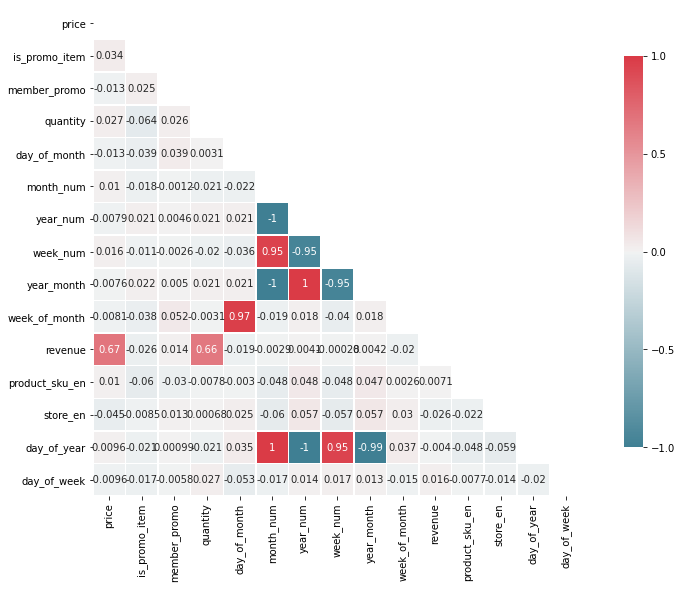

In [74]:
corr = model_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin = -1, vmax=1, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .8, 'ticks' : [-1, -.5, 0, 0.5, 1]})

plt.show()

In the correlation matrix, there are many cases on multicollinearity. Multicollinearity is a state where there exist a high intercorrelation or inter-associations among independent variables (predictors). If multicollinearity present in the data, the statistical inferences made about the data may not be reliable because we would not know which interdependent variable that will cause to have affects on the target variable. Variables that have the case of multicollinearity are the ones that are either close to 1 or close to -1. Closer to 1 means a strong positive correlation, while close to -1 means a strong negative correlation.

Strategy to deal with this issue:
* To avoid the multicollinearity issues, we either have to delete one of the correlated independent variables.
* What to delete? We could choose the one that have lower variance/standard deviation to be deleted. And keep the ones that have high variance, since our goal is to generalize our model. More variance, means more sample, means more different kinds of cases, more generalized.
* We could also delete the independent variable that has the most multicollinearity.
    

We deleted the revenue column because it is a derivation of other columns from the original data.

In [75]:
model_df_2 = model_df.drop(['revenue'], axis = 1)
model_df_2.head()

,date,price,is_promo_item,member_promo,quantity,day_of_month,month_num,year_num,week_num,year_month,week_of_month,product_sku_en,store_en,day_of_year,day_of_week
0,2019-11-29,147454.56,0.0,1.0,18.0,29,11,2019,48,201911,5,1,13,333,4
1,2020-01-15,4303058.84,1.0,0.0,3.0,15,1,2020,3,202001,3,2,6,15,2
2,2020-01-28,1742713.52,1.0,0.0,9.0,28,1,2020,5,202001,4,3,17,28,1
3,2019-12-05,4656476.03,0.0,1.0,8.0,5,12,2019,49,201912,1,4,7,339,3
4,2020-01-04,4774574.30,0.0,0.0,1.0,4,1,2020,1,202001,1,5,15,4,5


In [76]:
model_df_2.describe()[['day_of_month', 'week_of_month']]

,day_of_month,week_of_month
count,1734.000000,1734.000000
mean,15.521338,2.670127
std,8.677351,1.248499
min,1.000000,1.000000
25%,8.000000,2.000000
50%,16.000000,3.000000
75%,23.000000,4.000000
max,31.000000,5.000000


Delete the week_of_month because it has lower standard deviation. 

In [77]:
model_df_2.drop(['week_of_month'], axis = 1, inplace = True)
model_df_2.head()

,date,price,is_promo_item,member_promo,quantity,day_of_month,month_num,year_num,week_num,year_month,product_sku_en,store_en,day_of_year,day_of_week
0,2019-11-29,147454.56,0.0,1.0,18.0,29,11,2019,48,201911,1,13,333,4
1,2020-01-15,4303058.84,1.0,0.0,3.0,15,1,2020,3,202001,2,6,15,2
2,2020-01-28,1742713.52,1.0,0.0,9.0,28,1,2020,5,202001,3,17,28,1
3,2019-12-05,4656476.03,0.0,1.0,8.0,5,12,2019,49,201912,4,7,339,3
4,2020-01-04,4774574.30,0.0,0.0,1.0,4,1,2020,1,202001,5,15,4,5


Delete month_num & year_num columns because it has so many multicollinearity to the other independent variables.

In [78]:
model_df_2.drop(['year_num', 'month_num'], axis = 1, inplace = True)
model_df_2.head()

,date,price,is_promo_item,member_promo,quantity,day_of_month,week_num,year_month,product_sku_en,store_en,day_of_year,day_of_week
0,2019-11-29,147454.56,0.0,1.0,18.0,29,48,201911,1,13,333,4
1,2020-01-15,4303058.84,1.0,0.0,3.0,15,3,202001,2,6,15,2
2,2020-01-28,1742713.52,1.0,0.0,9.0,28,5,202001,3,17,28,1
3,2019-12-05,4656476.03,0.0,1.0,8.0,5,49,201912,4,7,339,3
4,2020-01-04,4774574.30,0.0,0.0,1.0,4,1,202001,5,15,4,5


In [79]:
model_df_2.describe()[['week_num', 'day_of_year', 'year_month']]

,week_num,day_of_year,year_month
count,1734.000000,1734.000000,1734.000000
mean,32.190888,227.190311,201941.588812
std,21.780283,151.238193,42.297069
min,1.000000,1.000000,201911.000000
25%,4.000000,23.000000,201911.000000
50%,46.000000,320.000000,201912.000000
75%,49.000000,341.000000,202001.000000
max,52.000000,365.000000,202001.000000


Drop week_num and year_month because the have the lower standard deviation.

In [80]:
model_df_2.drop(['week_num', 'year_month'], axis = 1, inplace = True)
model_df_2.head()

,date,price,is_promo_item,member_promo,quantity,day_of_month,product_sku_en,store_en,day_of_year,day_of_week
0,2019-11-29,147454.56,0.0,1.0,18.0,29,1,13,333,4
1,2020-01-15,4303058.84,1.0,0.0,3.0,15,2,6,15,2
2,2020-01-28,1742713.52,1.0,0.0,9.0,28,3,17,28,1
3,2019-12-05,4656476.03,0.0,1.0,8.0,5,4,7,339,3
4,2020-01-04,4774574.30,0.0,0.0,1.0,4,5,15,4,5


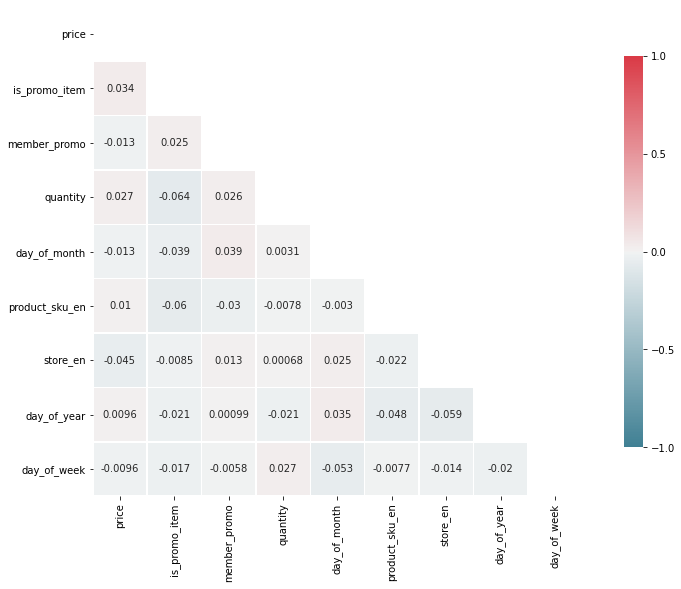

In [81]:
corr = model_df_2.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin = -1, vmax=1, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .8, 'ticks' : [-1, -.5, 0, 0.5, 1]})

plt.show()

In [82]:
model_df_2.corr()['quantity']

price             0.027132
is_promo_item    -0.064483
member_promo      0.026248
quantity          1.000000
day_of_month      0.003113
product_sku_en   -0.007779
store_en          0.000682
day_of_year      -0.020994
day_of_week       0.026880
Name: quantity, dtype: float64

Start Modeling

In [83]:
target = model_df['quantity']
X_train, X_test, y_train, y_test = train_test_split(model_df_2.drop(['date', 'quantity'], axis = 1), 
                                                    target, test_size = 0.2, random_state = 1234)

In [84]:
lin_reg = LinearRegression(normalize = True)

lin_reg_fit = lin_reg.fit(X_train, y_train)


lin_reg_R2 = lin_reg_fit.score(X_train, y_train)

lin_reg_intercept = lin_reg.intercept_

lin_reg_coef = lin_reg.coef_

lin_reg_R2

0.0055505563243795075

In [85]:
def lin_reg_metrics(model, X, y):
    yhat = model.predict(X)

    SS_Residual = sum((y-yhat)**2)
    SS_Total = sum((y-np.mean(y))**2)
    
    r_squared = 1 - (float(SS_Residual))/SS_Total
    adj_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1)
    
    return r_squared,adj_r_squared

In [86]:
print(lin_reg_R2)
lin_reg_metrics(lin_reg, X_test, y_test)

0.0055505563243795075


(-0.016830457980514302, -0.040897451068810486)

########## CALCULATE ROOT MEAN SQUARED ERROR ##########

In [87]:
# CALCULATE RMSE
print('RMSE Using Training set: {}'.format(np.sqrt(((lin_reg.predict(X_train) - y_train)**2).mean())))
print('RMSE Using Validation set: {}'.format(np.sqrt(((lin_reg.predict(X_test) - y_test)**2).mean())))

RMSE Using Training set: 5.824624445932358
RMSE Using Validation set: 5.588574362777772


In [88]:
# CALCULATE MAE
print('MAE Using Training set: {}'.format(abs(lin_reg.predict(X_train) - y_train).mean()))
print('MAE Using Validation set: {}'.format(abs(lin_reg.predict(X_test) - y_test).mean()))

MAE Using Training set: 5.045974041259087
MAE Using Validation set: 4.793166939527235


#### Try Lin_Reg2

Let's exclude features that have low correlation coefficient (Cutoff: < -0.005 & > 0.01)

In [89]:
lin_reg_2 = LinearRegression(normalize = True)

lin_reg_2_fit = lin_reg_2.fit(X_train.drop(['store_en'], axis = 1), y_train)

lin_reg_2_R2 = lin_reg_2_fit.score(X_train.drop(['store_en'], axis = 1), y_train)
lin_reg_2_R2

0.005482555466613692

In [90]:
print(lin_reg_2_R2)
lin_reg_metrics(lin_reg_2, X_test.drop(['store_en'], axis = 1), y_test)

0.005482555466613692


(-0.016163751048870356, -0.03714648337141346)

########## CALCULATE ROOT MEAN SQUARED ERROR ##########

In [91]:
np.sqrt(((lin_reg_2.predict(X_test.drop(['store_en'], axis = 1)) - y_test)**2).mean())

5.5867419273971874

In [92]:
# CALCULATE MAE
abs(lin_reg_2.predict(X_test.drop(['store_en'], axis = 1)) - y_test).mean()

4.791240326922722

Linear Regression with 8 Variables:
* RMSE : 5.588574362777771
* MAE : 4.793166939527237

Linear Regression with 7 Variables:
* RMSE : 5.586741927397188
* MAE : 4.791240326922718

In conclusion:
* Linear Regression would be used under the assumption of the existence of strongly and linearly correlated independent variables with the target variable.
* As we can see from the correlation matrix, there is no strong correlation with the target variable.
* Even though we have excluded a variable which had a weak correlation (store_en), both of the MAE and RMSE only decreased a little bit
* Due to lack of correlation of the predictors with the target, we would not choose this model and we should try to train with other models.
* We can conclude that using this model is under

### Polynomial Regression

In [93]:
def poly_regression(X_train, y_train, X_test, y_test, degree_up_to = 2, exclude_some = True, exclude_cols = []):
    
    fin_dict = {'degree_num':[],
                'RMSE_training':[],
                'RMSE_validation':[],
                'MAE_training':[],
                'MAE_validation':[]
               }
    exclude_dict = {'degree_num':[],
                    'RMSE_training':[],
                    'RMSE_validation':[],
                    'MAE_training':[],
                    'MAE_validation':[]
                   }
    
    for i in range(1, degree_up_to+1):
        poly_reg = PolynomialFeatures(degree = i)
        
        X_train_poly = poly_reg.fit_transform(X_train)
        X_test_poly = poly_reg.fit_transform(X_test)
        
        pol_reg = LinearRegression(normalize=True)
        pol_reg.fit(X_train_poly, y_train)
        
        fin_dict['degree_num'].append(i)
        fin_dict['RMSE_training'].append(np.sqrt(((pol_reg.predict(X_train_poly) - y_train)**2).mean()))
        fin_dict['RMSE_validation'].append(np.sqrt(((pol_reg.predict(X_test_poly) - y_test)**2).mean()))
        fin_dict['MAE_training'].append(abs(pol_reg.predict(X_train_poly) - y_train).mean())
        fin_dict['MAE_validation'].append(abs(pol_reg.predict(X_test_poly) - y_test).mean())
        
    if exclude_some:
        X_train_ex = X_train.drop(exclude_cols, axis = 1)
        X_test_ex = X_test.drop(exclude_cols, axis = 1)
        
        for i in range(1, degree_up_to+1):
            poly_reg_ex = PolynomialFeatures(degree = i)

            X_train_poly_ex = poly_reg_ex.fit_transform(X_train_ex)
            X_test_poly_ex = poly_reg_ex.fit_transform(X_test_ex)

            pol_reg_ex = LinearRegression(normalize=True)
            pol_reg_ex.fit(X_train_poly_ex, y_train)

            exclude_dict['degree_num'].append(i)
            exclude_dict['RMSE_training'].append(np.sqrt(((pol_reg_ex.predict(X_train_poly_ex) - y_train)**2).mean()))
            exclude_dict['RMSE_validation'].append(np.sqrt(((pol_reg_ex.predict(X_test_poly_ex) - y_test)**2).mean()))
            exclude_dict['MAE_training'].append(abs(pol_reg_ex.predict(X_train_poly_ex) - y_train).mean())
            exclude_dict['MAE_validation'].append(abs(pol_reg_ex.predict(X_test_poly_ex) - y_test).mean())
            
        return (pd.DataFrame(fin_dict), pd.DataFrame(exclude_dict))
    else:
        return pd.DataFrame(fin_dict)

In [94]:
ori_df, exclude_df = poly_regression(X_train, y_train, X_test, y_test, degree_up_to=10, 
                                     exclude_some=True, exclude_cols=['store_en'])

In [95]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = ori_df['degree_num'], y = ori_df['RMSE_training'], name = 'RMSE Training',
                        mode = 'lines+markers'))
fig.add_trace(go.Scatter(x = ori_df['degree_num'], y = ori_df['RMSE_validation'], name = 'RMSE Validation',
                        mode = 'lines+markers'))
fig.add_trace(go.Scatter(x = ori_df['degree_num'], y = ori_df['MAE_training'], name = 'MAE Training',
                        mode = 'lines+markers'))
fig.add_trace(go.Scatter(x = ori_df['degree_num'], y = ori_df['MAE_validation'], name = 'MAE Validation',
                        mode = 'lines+markers'))

fig.update_layout(title_text = 'Polynomial Model Error Evaluation (RMSE vs MAE) on Original DataFrame',
                 xaxis_title = 'Polynomial Degree',
                 yaxis_title = 'Error',
                  legend_orientation = 'h',
                   legend=dict(x=0, y=1.1))

fig.show()

In [96]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = exclude_df['degree_num'], y = exclude_df['RMSE_training'], name = 'RMSE Training',
                        mode = 'lines+markers'))
fig.add_trace(go.Scatter(x = exclude_df['degree_num'], y = exclude_df['RMSE_validation'], name = 'RMSE Validation',
                        mode = 'lines+markers'))
fig.add_trace(go.Scatter(x = exclude_df['degree_num'], y = exclude_df['MAE_training'], name = 'MAE Training',
                        mode = 'lines+markers'))
fig.add_trace(go.Scatter(x = exclude_df['degree_num'], y = exclude_df['MAE_validation'], name = 'MAE Validation',
                        mode = 'lines+markers'))

fig.update_layout(title_text = 'Polynomial Model Error Evaluation (RMSE vs MAE) Without "store" column',
                 xaxis_title = 'Polynomial Degree',
                 yaxis_title = 'Error',
                  legend_orientation = 'h',
                   legend=dict(x=0, y=1.1))

fig.show()

### Ridge Regression

In [97]:
def poly_ridge_regression(X_train, y_train, X_test, y_test, degree_up_to = 2, exclude_some = True, exclude_cols = []):
    
    fin_dict = {'degree_num':[],
                'RMSE_training':[],
                'RMSE_validation':[],
                'MAE_training':[],
                'MAE_validation':[]
               }
    exclude_dict = {'degree_num':[],
                    'RMSE_training':[],
                    'RMSE_validation':[],
                    'MAE_training':[],
                    'MAE_validation':[]
                   }
    
    for i in range(1, degree_up_to+1):
        poly_reg = PolynomialFeatures(degree = i)
        
        X_train_poly = poly_reg.fit_transform(X_train)
        X_test_poly = poly_reg.fit_transform(X_test)
        
        pol_reg = Ridge(normalize=True)
        pol_reg.fit(X_train_poly, y_train)
        
        fin_dict['degree_num'].append(i)
        fin_dict['RMSE_training'].append(np.sqrt(((pol_reg.predict(X_train_poly) - y_train)**2).mean()))
        fin_dict['RMSE_validation'].append(np.sqrt(((pol_reg.predict(X_test_poly) - y_test)**2).mean()))
        fin_dict['MAE_training'].append(abs(pol_reg.predict(X_train_poly) - y_train).mean())
        fin_dict['MAE_validation'].append(abs(pol_reg.predict(X_test_poly) - y_test).mean())
        
    if exclude_some:
        X_train_ex = X_train.drop(exclude_cols, axis = 1)
        X_test_ex = X_test.drop(exclude_cols, axis = 1)
        
        for i in range(1, degree_up_to+1):
            poly_reg_ex = PolynomialFeatures(degree = i)

            X_train_poly_ex = poly_reg_ex.fit_transform(X_train_ex)
            X_test_poly_ex = poly_reg_ex.fit_transform(X_test_ex)

            pol_reg_ex = Ridge(normalize=True)
            pol_reg_ex.fit(X_train_poly_ex, y_train)

            exclude_dict['degree_num'].append(i)
            exclude_dict['RMSE_training'].append(np.sqrt(((pol_reg_ex.predict(X_train_poly_ex) - y_train)**2).mean()))
            exclude_dict['RMSE_validation'].append(np.sqrt(((pol_reg_ex.predict(X_test_poly_ex) - y_test)**2).mean()))
            exclude_dict['MAE_training'].append(abs(pol_reg_ex.predict(X_train_poly_ex) - y_train).mean())
            exclude_dict['MAE_validation'].append(abs(pol_reg_ex.predict(X_test_poly_ex) - y_test).mean())
            
        return (pd.DataFrame(fin_dict), pd.DataFrame(exclude_dict))
    else:
        return pd.DataFrame(fin_dict)

In [98]:
poly_ridge_ori_df, poly_ridge_exclude_df = poly_ridge_regression(X_train, y_train, X_test, y_test, degree_up_to=10, 
                                             exclude_some=True, exclude_cols=['store_en'])

In [99]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = poly_ridge_ori_df['degree_num'], y = poly_ridge_ori_df['RMSE_training'], name = 'RMSE Training',
                        mode = 'lines+markers'))
fig.add_trace(go.Scatter(x = poly_ridge_ori_df['degree_num'], y = poly_ridge_ori_df['RMSE_validation'], name = 'RMSE Validation',
                        mode = 'lines+markers'))
fig.add_trace(go.Scatter(x = poly_ridge_ori_df['degree_num'], y = poly_ridge_ori_df['MAE_training'], name = 'MAE Training',
                        mode = 'lines+markers'))
fig.add_trace(go.Scatter(x = poly_ridge_ori_df['degree_num'], y = poly_ridge_ori_df['MAE_validation'], name = 'MAE Validation',
                        mode = 'lines+markers'))

fig.update_layout(title_text = 'Polynomial Ridge Model Error Evaluation (RMSE vs MAE) on Original DataFrame',
                 xaxis_title = 'Polynomial Degree',
                 yaxis_title = 'Error',
                  legend_orientation = 'h',
                   legend=dict(x=0, y=1.1))

fig.show()

In [101]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = poly_ridge_exclude_df['degree_num'], y = poly_ridge_exclude_df['RMSE_training'], name = 'RMSE Training',
                        mode = 'lines+markers'))
fig.add_trace(go.Scatter(x = poly_ridge_exclude_df['degree_num'], y = poly_ridge_exclude_df['RMSE_validation'], name = 'RMSE Validation',
                        mode = 'lines+markers'))
fig.add_trace(go.Scatter(x = poly_ridge_exclude_df['degree_num'], y = poly_ridge_exclude_df['MAE_training'], name = 'MAE Training',
                        mode = 'lines+markers'))
fig.add_trace(go.Scatter(x = poly_ridge_exclude_df['degree_num'], y = poly_ridge_exclude_df['MAE_validation'], name = 'MAE Validation',
                        mode = 'lines+markers'))

fig.update_layout(title_text = 'Polynomial Ridge Model Error Evaluation (RMSE vs MAE) Without "store" column',
                 xaxis_title = 'Polynomial Degree',
                 yaxis_title = 'Error',
                  legend_orientation = 'h',
                   legend=dict(x=0, y=1.1))

fig.show()

### Lasso Regression

In [102]:
lasso_reg = Lasso(normalize = True, alpha = 1,)
lasso_reg.fit(X_train, y_train)

print('RMSE Validation : {}'.format(np.sqrt(((lasso_reg.predict(X_test) - y_test)**2).mean())))
print('The coefficients are : {}'.format(lasso_reg.coef_))
print('The intercept is : {}'.format(lasso_reg.intercept_))

RMSE Validation : 5.61793861975897
The coefficients are : [ 0. -0.  0. -0. -0. -0. -0.  0.]
The intercept is : 10.674837779379956


Unfortunately, when we used Lasso Regression, it turns out giving penalty so much to the point where all of the coefficients are 0. And all that's left is the intercept of 10.6748. This means that this algorithm will only predict the intercept all the time. Hence, we will not consider using this algorithm for comparison.

## Tree Models

In [103]:
fig = go.Figure()

rmse_train_list = []
rmse_val_list = []

mae_train_list = []
mae_val_list = []

for i in range(1,16):
    
    d_tree = DecisionTreeRegressor(random_state = 1234, criterion = 'mae', max_depth = i)
    d_tree.fit(X_train, y_train)
    
    rmse_train_list.append(np.sqrt(((d_tree.predict(X_train) - y_train)**2).mean()))
    rmse_val_list.append(np.sqrt(((d_tree.predict(X_test) - y_test)**2).mean()))
    mae_train_list.append(abs(d_tree.predict(X_train) - y_train).mean())
    mae_val_list.append(abs(d_tree.predict(X_test) - y_test).mean())
    
fig.add_trace(go.Scatter(x = list(range(1,16)), y = rmse_train_list, mode = 'lines+markers', name = 'RMSE Train'))    
fig.add_trace(go.Scatter(x = list(range(1,16)), y = rmse_val_list, mode = 'lines+markers', name = 'RMSE Validation'))
fig.add_trace(go.Scatter(x = list(range(1,16)), y = mae_train_list, mode = 'lines+markers', name = 'MAE Train'))
fig.add_trace(go.Scatter(x = list(range(1,16)), y = mae_val_list, mode = 'lines+markers', name = 'MAE Validation'))

fig.update_layout(title_text = 'Decision Tree Train and Validation Set RMSE ',
                 xaxis_title = 'Max Depth',
                 yaxis_title = 'Error',
                 legend_orientation = 'h',
                  legend = dict(x=0,y=1.1)
                 )
fig.show()

In [104]:
param = {'max_depth' : range(1,30), 
         'max_features' : range(1, X_train.shape[1] + 1), 
         'splitter':['best', 'random']
        }

grid = GridSearchCV(d_tree, param_grid = param, cv=10,n_jobs = -1, scoring='neg_mean_absolute_error')
grid.fit(X_train, y_train) 

print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)


{'max_depth': 1, 'max_features': 5, 'splitter': 'best'}
-5.045699092899593
DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=1,
                      max_features=5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=1234, splitter='best')


In [105]:
dectree_grid = grid.best_estimator_
feature_importances = pd.DataFrame(dectree_grid.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance'])
feature_importances.sort_values(by='importance', ascending=False).head(10)

,importance
product_sku_en,1.0
price,0.0
is_promo_item,0.0
member_promo,0.0
day_of_month,0.0
store_en,0.0
day_of_year,0.0
day_of_week,0.0


In [106]:
print('RMSE Train : {}'.format(np.sqrt(((dectree_grid.predict(X_train) - y_train)**2).mean())))
print('RMSE Validation : {}'.format(np.sqrt(((dectree_grid.predict(X_test) - y_test)**2).mean())))
print('MAE Train : {}'.format(abs(dectree_grid.predict(X_train) - y_train).mean()))
print('MAE Validation : {}'.format(abs(dectree_grid.predict(X_test) - y_test).mean()))

RMSE Train : 5.833918671494249
RMSE Validation : 5.636439696259308
MAE Train : 5.029560201874549
MAE Validation : 4.847262247838617


Although the MAE Validation has gone down, but the feature importance can be considered as absurd. The algorithm only detects that product_sku is the only important feature.

### Random Forest

In [107]:
rf = RandomForestRegressor(n_estimators=1000, criterion = 'mae', n_jobs = -1, random_state=1234)

rf.fit(X_train, y_train)

print('RMSE Train : {}'.format(np.sqrt(((rf.predict(X_train) - y_train)**2).mean())))
print('RMSE Validation : {}'.format(np.sqrt(((rf.predict(X_test) - y_test)**2).mean())))
print('MAE Train : {}'.format(abs(rf.predict(X_train) - y_train).mean()))
print('MAE Validation : {}'.format(abs(rf.predict(X_test) - y_test).mean()))

RMSE Train : 2.3717976503631597
RMSE Validation : 5.989392584356021
MAE Train : 2.039980173035329
MAE Validation : 5.144479827089336


### XGBoost Regressor

In [108]:
start_time = time.time()

xgb_reg = XGBRegressor(n_estimators=100, objective='reg:squarederror', random_state = 1234)

xgb_reg.fit(X_train, y_train, eval_set = [(X_test, y_test)], eval_metric = 'rmse', early_stopping_rounds = 30)

print("--- %s seconds ---" % (time.time() - start_time))

[0]	validation_0-rmse:9.93755
Will train until validation_0-rmse hasn't improved in 30 rounds.
[1]	validation_0-rmse:9.1973
[2]	validation_0-rmse:8.55959
[3]	validation_0-rmse:8.01748
[4]	validation_0-rmse:7.5434
[5]	validation_0-rmse:7.15628
[6]	validation_0-rmse:6.83444
[7]	validation_0-rmse:6.55825
[8]	validation_0-rmse:6.34185
[9]	validation_0-rmse:6.15608
[10]	validation_0-rmse:6.01452
[11]	validation_0-rmse:5.90797
[12]	validation_0-rmse:5.81846
[13]	validation_0-rmse:5.75379
[14]	validation_0-rmse:5.70457
[15]	validation_0-rmse:5.66234
[16]	validation_0-rmse:5.63304
[17]	validation_0-rmse:5.61618
[18]	validation_0-rmse:5.60698
[19]	validation_0-rmse:5.59981
[20]	validation_0-rmse:5.60274
[21]	validation_0-rmse:5.6069
[22]	validation_0-rmse:5.61234
[23]	validation_0-rmse:5.61356
[24]	validation_0-rmse:5.62601
[25]	validation_0-rmse:5.63364
[26]	validation_0-rmse:5.64487
[27]	validation_0-rmse:5.65219
[28]	validation_0-rmse:5.65158
[29]	validation_0-rmse:5.65487
[30]	validation_0-

Tuning n_estimators

In [109]:
xgb_param1 = xgb_reg.get_xgb_params()
xgtrain1 = DMatrix(X_train.values, label=y_train.values)

cvresult1 = cv(xgb_param1, xgtrain1, num_boost_round=xgb_reg.get_params()['n_estimators'], nfold=10,
            metrics='rmse', early_stopping_rounds=30)

In [110]:
cvresult1

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,10.856636,0.043102,10.859516,0.420760
1,10.089733,0.039051,10.107532,0.415965
2,9.421125,0.035710,9.449823,0.407482
3,8.839414,0.032645,8.880715,0.393135
4,8.337931,0.030094,8.393383,0.388384
5,7.905255,0.027147,7.974501,0.376932
6,7.535473,0.026594,7.622103,0.366377
7,7.218403,0.025999,7.323305,0.352342
8,6.950191,0.024143,7.075010,0.339911
9,6.721911,0.025225,6.862280,0.328447


In [111]:
xgb_reg.set_params(n_estimators = cvresult1.shape[0])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=32,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=1234, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [112]:
start_time = time.time()

xgb_reg.fit(X_train, y_train, eval_set = [(X_test, y_test)], eval_metric = 'rmse', early_stopping_rounds = 30)

print("--- %s seconds ---" % (time.time() - start_time))

[0]	validation_0-rmse:9.93755
Will train until validation_0-rmse hasn't improved in 30 rounds.
[1]	validation_0-rmse:9.1973
[2]	validation_0-rmse:8.55959
[3]	validation_0-rmse:8.01748
[4]	validation_0-rmse:7.5434
[5]	validation_0-rmse:7.15628
[6]	validation_0-rmse:6.83444
[7]	validation_0-rmse:6.55825
[8]	validation_0-rmse:6.34185
[9]	validation_0-rmse:6.15608
[10]	validation_0-rmse:6.01452
[11]	validation_0-rmse:5.90797
[12]	validation_0-rmse:5.81846
[13]	validation_0-rmse:5.75379
[14]	validation_0-rmse:5.70457
[15]	validation_0-rmse:5.66234
[16]	validation_0-rmse:5.63304
[17]	validation_0-rmse:5.61618
[18]	validation_0-rmse:5.60698
[19]	validation_0-rmse:5.59981
[20]	validation_0-rmse:5.60274
[21]	validation_0-rmse:5.6069
[22]	validation_0-rmse:5.61234
[23]	validation_0-rmse:5.61356
[24]	validation_0-rmse:5.62601
[25]	validation_0-rmse:5.63364
[26]	validation_0-rmse:5.64487
[27]	validation_0-rmse:5.65219
[28]	validation_0-rmse:5.65158
[29]	validation_0-rmse:5.65487
[30]	validation_0-

In [113]:
from sklearn.metrics import mean_squared_error, make_scorer

the_scorer = make_scorer(mean_squared_error)

param_test1 = {
 'max_depth':[2, 3, 5, 7, 11, 13, 17],
 'min_child_weight':range(1,6),
 'n_estimators':[32]  # AS the result from the cross validation for finding n_estimators
}

gsearch1 = GridSearchCV(estimator = xgb_reg, param_grid = param_test1, scoring=the_scorer,n_jobs=-1,iid=False, cv=10)

## Fit 350 times
gsearch1.fit(X_train,y_train)

gsearch1.best_params_ , np.sqrt(gsearch1.best_score_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



({'max_depth': 17, 'min_child_weight': 1, 'n_estimators': 32},
 6.464740602929939)

In [114]:
xgb_reg.set_params(max_depth = 17,  min_child_weight= 1 )
xgb_reg.fit(X_train, y_train, eval_set = [(X_test, y_test)], eval_metric = 'rmse', early_stopping_rounds = 30)

[0]	validation_0-rmse:10.0079
Will train until validation_0-rmse hasn't improved in 30 rounds.
[1]	validation_0-rmse:9.38882
[2]	validation_0-rmse:8.85342
[3]	validation_0-rmse:8.3632
[4]	validation_0-rmse:7.94117
[5]	validation_0-rmse:7.61549
[6]	validation_0-rmse:7.34133
[7]	validation_0-rmse:7.10822
[8]	validation_0-rmse:6.90682
[9]	validation_0-rmse:6.73261
[10]	validation_0-rmse:6.59447
[11]	validation_0-rmse:6.49588
[12]	validation_0-rmse:6.43256
[13]	validation_0-rmse:6.37582
[14]	validation_0-rmse:6.33617
[15]	validation_0-rmse:6.31675
[16]	validation_0-rmse:6.29511
[17]	validation_0-rmse:6.28277
[18]	validation_0-rmse:6.27554
[19]	validation_0-rmse:6.271
[20]	validation_0-rmse:6.26663
[21]	validation_0-rmse:6.26365
[22]	validation_0-rmse:6.26971
[23]	validation_0-rmse:6.28506
[24]	validation_0-rmse:6.30589
[25]	validation_0-rmse:6.3167
[26]	validation_0-rmse:6.31941
[27]	validation_0-rmse:6.33542
[28]	validation_0-rmse:6.3554
[29]	validation_0-rmse:6.36273
[30]	validation_0-rm

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=17, min_child_weight=1, missing=None, n_estimators=32,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=1234, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

Tune Gamma

In [115]:
# Recalibrate

xgb_param2 = xgb_reg.get_xgb_params()
cvresult2 = cv(xgb_param2, xgtrain1, num_boost_round=xgb_reg.get_params()['n_estimators'], nfold=10,
            metrics='rmse', early_stopping_rounds=30)
cvresult2

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,10.801234,0.046403,10.938506,0.425041
1,9.954065,0.040502,10.271582,0.415727
2,9.174192,0.032888,9.705732,0.414205
3,8.462006,0.031354,9.211876,0.408491
4,7.814496,0.028030,8.789205,0.398985
5,7.227204,0.033512,8.430907,0.415227
6,6.686376,0.028275,8.112303,0.410049
7,6.189551,0.035267,7.848474,0.393951
8,5.749846,0.040877,7.613397,0.394925
9,5.350822,0.050653,7.420733,0.384963


In [116]:
xgb_reg.set_params(n_estimators = cvresult2.shape[0])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=17, min_child_weight=1, missing=None, n_estimators=32,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=1234, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [117]:
param_test2 = {
 'gamma':[0, 0.03, 0.05, 0.07, 0.09, 0.1] 
}

gsearch2 = GridSearchCV(estimator = xgb_reg, param_grid = param_test2, scoring=the_scorer,n_jobs=-1,iid=False, cv=10)

gsearch2.fit(X_train,y_train)

gsearch2.best_params_ , np.sqrt(gsearch2.best_score_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



({'gamma': 0.05}, 6.465094807680028)

In [118]:
xgb_reg.set_params(gamma = 0.05)
xgb_reg.fit(X_train, y_train, eval_set = [(X_test, y_test)], eval_metric = 'rmse', early_stopping_rounds = 30)

[0]	validation_0-rmse:10.0079
Will train until validation_0-rmse hasn't improved in 30 rounds.
[1]	validation_0-rmse:9.38882
[2]	validation_0-rmse:8.85342
[3]	validation_0-rmse:8.36318
[4]	validation_0-rmse:7.94076
[5]	validation_0-rmse:7.61467
[6]	validation_0-rmse:7.34055
[7]	validation_0-rmse:7.10739
[8]	validation_0-rmse:6.90617
[9]	validation_0-rmse:6.73532
[10]	validation_0-rmse:6.59672
[11]	validation_0-rmse:6.48417
[12]	validation_0-rmse:6.43225
[13]	validation_0-rmse:6.36541
[14]	validation_0-rmse:6.31867
[15]	validation_0-rmse:6.27745
[16]	validation_0-rmse:6.26866
[17]	validation_0-rmse:6.26221
[18]	validation_0-rmse:6.25603
[19]	validation_0-rmse:6.25754
[20]	validation_0-rmse:6.25173
[21]	validation_0-rmse:6.24623
[22]	validation_0-rmse:6.24996
[23]	validation_0-rmse:6.24817
[24]	validation_0-rmse:6.25707
[25]	validation_0-rmse:6.27086
[26]	validation_0-rmse:6.28078
[27]	validation_0-rmse:6.29085
[28]	validation_0-rmse:6.30245
[29]	validation_0-rmse:6.31251
[30]	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.05,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=17, min_child_weight=1, missing=None, n_estimators=32,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=1234, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

Tune Regularization

In [119]:
# REcalibrate
xgb_param3 = xgb_reg.get_xgb_params()

cvresult3 = cv(xgb_param3, xgtrain1, num_boost_round=xgb_reg.get_params()['n_estimators'], nfold=10,
            metrics='rmse', early_stopping_rounds=30)
cvresult3

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,10.801234,0.046403,10.938559,0.425038
1,9.954067,0.040504,10.271164,0.415710
2,9.174200,0.032887,9.704827,0.414301
3,8.461823,0.031285,9.216307,0.404813
4,7.813993,0.028002,8.790761,0.397591
5,7.225406,0.033015,8.436633,0.407823
6,6.685994,0.029739,8.117528,0.400605
7,6.184771,0.032552,7.856476,0.388117
8,5.744849,0.039341,7.623438,0.386998
9,5.346852,0.053041,7.418962,0.378152


In [120]:
xgb_reg.set_params(n_estimators = cvresult3.shape[0])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.05,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=17, min_child_weight=1, missing=None, n_estimators=32,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=1234, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [121]:
param_test3 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05],
 'reg_lambda':[0.3,0.4, 0.5]
}

gsearch3 = GridSearchCV(estimator = xgb_reg, param_grid = param_test3, scoring=the_scorer,n_jobs=4,iid=False, cv=10)

gsearch3.fit(X_train,y_train)

gsearch3.best_params_ , np.sqrt(gsearch3.best_score_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



({'reg_alpha': 0.001, 'reg_lambda': 0.3}, 6.5588200612472)

In [122]:
xgb_reg.set_params(reg_alpha = 0.005, reg_lambda = 0.3)
xgb_reg.fit(X_train, y_train, eval_set = [(X_test, y_test)], eval_metric = 'rmse', early_stopping_rounds = 30)

[0]	validation_0-rmse:10.0162
Will train until validation_0-rmse hasn't improved in 30 rounds.
[1]	validation_0-rmse:9.36032
[2]	validation_0-rmse:8.803
[3]	validation_0-rmse:8.34334
[4]	validation_0-rmse:7.96163
[5]	validation_0-rmse:7.61233
[6]	validation_0-rmse:7.33986
[7]	validation_0-rmse:7.09966
[8]	validation_0-rmse:6.90731
[9]	validation_0-rmse:6.79671
[10]	validation_0-rmse:6.69139
[11]	validation_0-rmse:6.60872
[12]	validation_0-rmse:6.56303
[13]	validation_0-rmse:6.51923
[14]	validation_0-rmse:6.49242
[15]	validation_0-rmse:6.4727
[16]	validation_0-rmse:6.45611
[17]	validation_0-rmse:6.45072
[18]	validation_0-rmse:6.43587
[19]	validation_0-rmse:6.43154
[20]	validation_0-rmse:6.42074
[21]	validation_0-rmse:6.41816
[22]	validation_0-rmse:6.42807
[23]	validation_0-rmse:6.4339
[24]	validation_0-rmse:6.44487
[25]	validation_0-rmse:6.44942
[26]	validation_0-rmse:6.45773
[27]	validation_0-rmse:6.46401
[28]	validation_0-rmse:6.47052
[29]	validation_0-rmse:6.479
[30]	validation_0-rms

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.05,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=17, min_child_weight=1, missing=None, n_estimators=32,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=1234, reg_alpha=0.005, reg_lambda=0.3,
             scale_pos_weight=1, seed=None, silent=None, subsample=1,
             verbosity=1)

## CONCLUSION
| Model | Features | Error |
| --- | --- | --- |
| Polynomial Regression | All Features | RMSE Val Error: 5.697 |
| Polynomial Regression | All Features | MAE Val Error: 5.189 |
| Polynomial Regression | Exclude "store" | RMSE Val Error: 6.556 |
| Polynomial Regression | Exclude "store" | MAE Val Error: 5.44 |
| Polynomial Regression + L2 Regularization | All Features | RMSE Val Error: 5.624 |
| Polynomial Regression + L2 Regularization | All Features | MAE Val Error: 4.828 |
| Polynomial Regression + L2 Regularization | Exclude "store" | RMSE Val Error: 5.662 |
| Polynomial Regression + L2 Regularization | Exclude "store" | MAE Val Error: 4.864 |
| XGBoost Regressor | All Features | RMSE Val Error: 5.59981 |

* The best model between 3 models is using XGBoostRegressor with Root Mean Squared Error is 5.59981
* Polynomial Regression is a good second choice the Polynomial Regression with L2 Regularization 
* XGBoostRegressor will take time to be tuned, since there are so many hyperparameters to be tuned.
* While Regularization only takes alpha (penalty term) to be tuned to overcome overfitting issues.
